## Model selection 

Here, we demonstrate the modeling framework of experimenting the performance of many ML models to decide the best for the weather stations considered here. We follow the previous exercise on predictor selection method and the other related steps. The only thing we are adding here is to define many learning models, trained them individually to evaluate their performance. 

In [1]:
# import all the models required
import os 
import sys 
import pandas as pd 
import numpy as np 
from collections import OrderedDict
import socket

# modules related to pyESD

from pyESD.Weatherstation import read_station_csv
from pyESD.standardizer import MonthlyStandardizer
from pyESD.ESD_utils import store_pickle, store_csv
from pyESD.splitter import KFold
from pyESD.ESD_utils import Dataset
from pyESD.Weatherstation import read_weatherstationnames

In [2]:
# define the predictors without teleconnection indices
predictors = ["t2m", "tp","msl", "v10", "u10", "NAO", "EA", "SCAN", "EAWR",
              "u250", "u850", "u500","u700", "u1000","v250", "v850", "v500","v700", "v1000",
              "r250", "r850", "r500","r700", "r1000", "z250", "z500", "z700", "z850", "z1000", 
              "t250", "t850", "t500","t700", "t1000","dtd250", "dtd850", "dtd500","dtd700", "dtd1000"
              ]

# date-range for model training and validation
from1958to2010 = pd.date_range(start="1958-01-01", end="2010-12-31", freq="MS")

# date-range for testing model
from2011to2020 = pd.date_range(start="2011-01-01", end="2020-12-31", freq="MS")

#full-time range
from1958to2020 = pd.date_range(start="1958-01-01", end="2020-12-31", freq="MS")

### control function

Define the control function that performs the predictor selection and model training.
1. read the station data as object that would apply all the ESD routines
2. set predictors with the list of predictors defined and the radius to construct the regional means
3. standardize the data with any of the standardizers. Here we use the MonthlyStandardizer method
4. defined the scoring metrics to be used for the validation
5. set the model to be used for the ESD training (here we will use the LassoLarsCV model)
6. fit the model, here we have to define the predictor selector method (here: Recursive ) to be used for selecting the predictors
7. get the selected predictors 
8. use the cross_validate_predict to get the cross-validation metrics of the model training 
9. store the selected predictors 
10. stored the validation metrics

In [3]:
def run_model_selection(variable, estimator, cachedir, stationnames,
                    station_datadir, radius, base_estimators=None,
                       final_estimator=None):
    """
    Run an experiment using pyESD to perform predictor selection for a given variable.

    Args:
        variable (str): The target variable to predict, here Precipitation.
        regressor (str): The regression method to use, here we use the RidgeCV regression to test all the predictor selection
        methods.
        selector_method (str): The method for selecting predictors ("Recursive", "TreeBased", "Sequential").
        cachedir (str): Directory to store cached results, here all the files would be stored in the .
        stationnames (list): List of station names. it would be loaded from the read_data file
        station_datadir (str): Directory containing station data files: this is also set in the read the data file
        predictors (list): List of predictor variables.
        predictordir (str): Directory containing predictor data files.
        radius (float): Radius for selecting predictors: also defined in the read_data file
        base_estimators (list): for stacking regressor base models 
        final_estimator (str): for stacking regressor meta-learner
    """
    num_of_stations = len(stationnames)

    # Loop through all stations
    for i in range(num_of_stations):
        stationname = stationnames[i]
        
        # set the exact path for the station  data
        station_dir = os.path.join(station_datadir, stationname + ".csv")
        
        # 1. create the station object using the read_station_csv and apply all the methods on the station object
        
        SO_instance = read_station_csv(filename=station_dir, varname=variable)

        # 2. Setting predictors (generate the predictors using the defined predictor names)
        SO_instance.set_predictors(variable, predictors, predictordir, radius)

        # 3. Setting standardizer
        SO_instance.set_standardizer(variable, standardizer=MonthlyStandardizer(detrending=False, scaling=False))
        
        
        # 4. define the scoring metrics
        scoring = ["neg_root_mean_squared_error", "r2", "neg_mean_absolute_error"]
        
        # 5. Setting model with cross-validation
        if estimator == "Stacking":
            
            SO_instance.set_model(variable, method=estimator, ensemble_learning=True, 
                     estimators=base_estimators, final_estimator_name=final_estimator, daterange=from1958to2010,
                     predictor_dataset=ERA5Data, cv=KFold(n_splits=10),
                     scoring = scoring)
        else:
            
            
            SO_instance.set_model(variable, method=estimator, cv=KFold(n_splits=10),
                         scoring = scoring)

        # 6. Fitting model with predictor selector option
        SO_instance.fit(variable, from1958to2010, ERA5Data, fit_predictors=True, predictor_selector=True,
                            selector_method="Recursive", selector_regressor="ARD",
                            cal_relative_importance=False)
        
        # 7. cross-validate and predict
        score_fit, ypred_fit = SO_instance.cross_validate_and_predict(variable,  from1958to2010, ERA5Data,)

        # 8. evaluate model on the test set
        score_test = SO_instance.evaluate(variable,  from2011to2020, ERA5Data,)
        
        # 9. make predictions for the test and train period
        ypred_train = SO_instance.predict(variable, from1958to2010, ERA5Data)
        
        ypred_test = SO_instance.predict(variable, from2011to2020, ERA5Data)
        
        # get the observed datasets for comparisons 
        y_obs_train = SO_instance.get_var(variable, from1958to2010, anomalies=True)
        
        y_obs_test = SO_instance.get_var(variable, from2011to2020, anomalies=True)
        
        y_obs_full = SO_instance.get_var(variable, from1958to2020, anomalies=True)

        # 9-10. Storing results using pickle
        predictions = pd.DataFrame({
            "obs_full": y_obs_full,
            "obs_train" : y_obs_train,
            "obs_test": y_obs_test,
            "ERA5 1958-2010" : ypred_train,
            "ERA5 2011-2020" : ypred_test})
        
        
        store_pickle(stationname, "validation_score_" + estimator, score_fit, cachedir)
        store_pickle(stationname, "test_score_" + estimator, score_test, cachedir)
        store_csv(stationname, "predictions_" + estimator, predictions, cachedir)
      

In [4]:
from read_data import radius, station_prec_datadir, stationnames_prec, ERA5Data, predictordir, cachedir_prec

## Perfom the experiment for all models

In [5]:
final_estimator = "LassoLarsCV"

base_estimators = ["LassoLarsCV", "ARD", "MLP", "RandomForest", "XGBoost", "Bagging"]


estimators = ["LassoLarsCV", "ARD", "MLP", "RandomForest", "XGBoost", "Bagging", "Stacking"]

In [6]:
#for estimator in estimators:
    run_model_selection(variable="Precipitation", estimator=estimator, cachedir=cachedir_prec, stationnames=stationnames_prec,
                        station_datadir=station_prec_datadir,
                        radius=radius, base_estimators=base_estimators,
                           final_estimator=final_estimator)

Freiburg 48.0232 7.8343 236.0
Regenerating predictor data for t2m using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for tp using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for msl using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for v10 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for u10 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for NAO using dataset ERA5 with loading patterns and params from ERA5 and ERA5
The EoF Package implementation of EOF analysis is used! for the teleconnections
Regenerating predictor data for EA using dataset ERA5 with loading patterns and params from ERA5 and ERA5
The EoF Package implementation of EOF analysis is used! for the teleconnections
Regenerating predictor data for SCAN using dataset ERA5 with lo

Regenerating predictor data for t250 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for t850 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for t500 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for t700 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for t1000 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd250 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd850 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd500 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd700 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predic

Regenerating predictor data for t700 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for t1000 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd250 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd850 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd500 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd700 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd1000 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
RMSE: 22.891656
Nach-Sutcliffe Efficiency(NSE): 0.554393
Mean Squared Error): 22.89
Mean Absolute Error): 17.14
Explained Variance: 0.55
R² (Coefficient of determinaiton): 0.55
Maximum error: 88.742235
Adjusted R²: 0.63
Mannheim 49.

Regenerating predictor data for t700 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for t1000 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd250 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd850 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd500 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd700 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd1000 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
RMSE: 15.838567
Nach-Sutcliffe Efficiency(NSE): 0.640846
Mean Squared Error): 15.84
Mean Absolute Error): 12.54
Explained Variance: 0.66
R² (Coefficient of determinaiton): 0.64
Maximum error: 40.988440
Adjusted R²: 0.68
Nürnberg 49.

Regenerating predictor data for t1000 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd250 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd850 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd500 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd700 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd1000 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
RMSE: 16.587541
Nach-Sutcliffe Efficiency(NSE): 0.617803
Mean Squared Error): 16.59
Mean Absolute Error): 13.20
Explained Variance: 0.65
R² (Coefficient of determinaiton): 0.62
Maximum error: 56.121438
Adjusted R²: 0.66
Stuttgart (Schnarrenberg) 48.8281 9.2 314.0
Regenerating predictor data for t2m using dataset ERA5 with loading patterns

Regenerating predictor data for dtd500 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd700 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
Regenerating predictor data for dtd1000 using dataset ERA5 with loading patterns and params from ERA5 and ERA5
RMSE: 21.010624
Nach-Sutcliffe Efficiency(NSE): 0.483127
Mean Squared Error): 21.01
Mean Absolute Error): 14.85
Explained Variance: 0.49
R² (Coefficient of determinaiton): 0.48
Maximum error: 106.725526
Adjusted R²: 0.57
Freiburg 48.0232 7.8343 236.0
13 : optimal number of predictors and selected variables are Index(['t2m', 'tp', 'v10', 'u10', 'NAO', 'SCAN', 'u850', 'v1000', 'r1000',
       't500', 'dtd250', 'dtd700', 'dtd1000'],
      dtype='object')
RMSE: 24.444096
Nach-Sutcliffe Efficiency(NSE): 0.560790
Mean Squared Error): 24.44
Mean Absolute Error): 18.86
Explained Variance: 0.61
R² (Coefficient of determinaiton): 0.56
Maximum error: 84.024614
Adjusted R²

Konstanz 47.6952 9.1307 428.0
6 : optimal number of predictors and selected variables are Index(['t2m', 'tp', 'u10', 'EAWR', 'v700', 'r700'], dtype='object')
RMSE: 25.670934
Nach-Sutcliffe Efficiency(NSE): 0.439622
Mean Squared Error): 25.67
Mean Absolute Error): 18.10
Explained Variance: 0.44
R² (Coefficient of determinaiton): 0.44
Maximum error: 98.924269
Adjusted R²: 0.54
Mannheim 49.5063 8.5584 98.0
34 : optimal number of predictors and selected variables are Index(['tp', 'msl', 'v10', 'u10', 'NAO', 'EA', 'SCAN', 'EAWR', 'u250', 'u850',
       'u500', 'u700', 'u1000', 'v250', 'v850', 'v500', 'v700', 'v1000',
       'r250', 'r850', 'r500', 'r700', 'r1000', 'z250', 't250', 't850', 't500',
       't700', 't1000', 'dtd250', 'dtd850', 'dtd500', 'dtd700', 'dtd1000'],
      dtype='object')
RMSE: 17.730173
Nach-Sutcliffe Efficiency(NSE): 0.549935
Mean Squared Error): 17.73
Mean Absolute Error): 13.63
Explained Variance: 0.58
R² (Coefficient of determinaiton): 0.55
Maximum error: 52.220980


## Plot the inter-model performance with pyESD.plot

In [6]:
path_to_results = "C:/Users/dboateng/Desktop/Python_scripts/ESD_Package/examples/tutorials/model_selection/"

In [7]:
from pyESD.plot import boxplot, scatterplot, lineplot
from pyESD.plot_utils import *

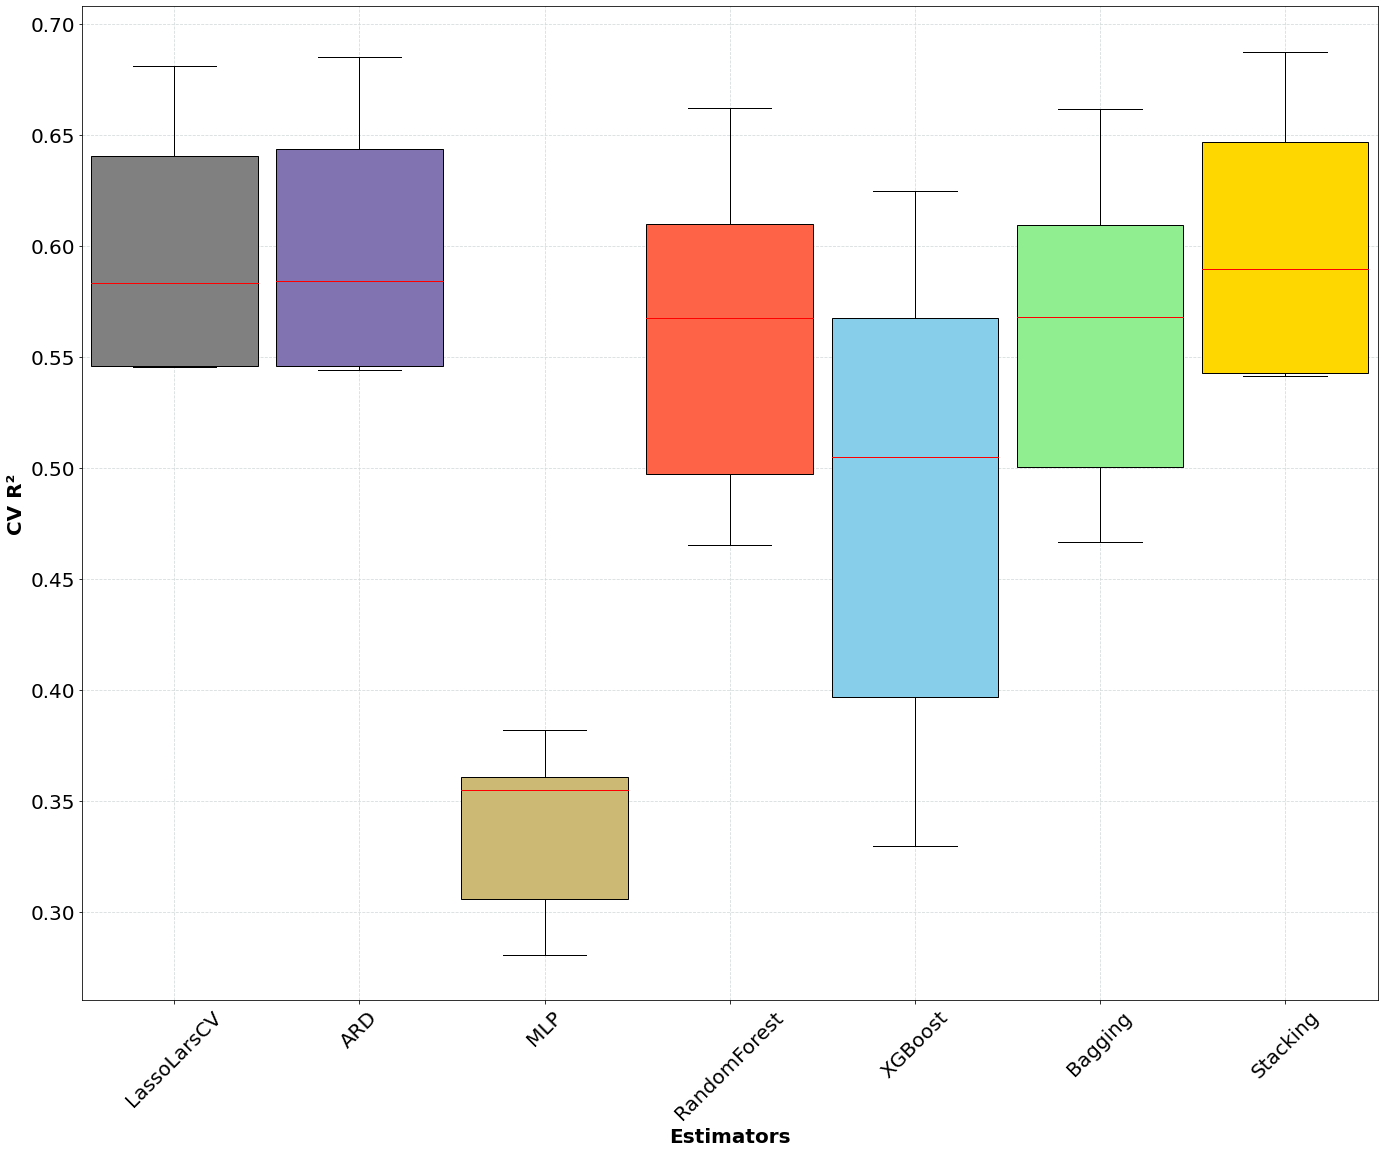

In [8]:
colors = [grey, purple, lightbrown, tomato, skyblue, lightgreen, gold]
boxplot(estimators, stationnames_prec, path_to_results,  
                varname="test_r2", filename="validation_score_", xlabel="Estimators",
                ylabel="CV R²", colors = colors, patch_artist=(True))

## Results
The results indicate that the regularized and bayesian models perform reasonably well. Also stacking regressor of all the models was equally better as the best model even though some of the models performed bad. This implies that stacking the good models would yield a better results.

### Prediction example
The using the plot function to visualize the prediction of one of the staion using the stacking regressor

extracting information for the station:  Konstanz
extracting information for the station:  Konstanz


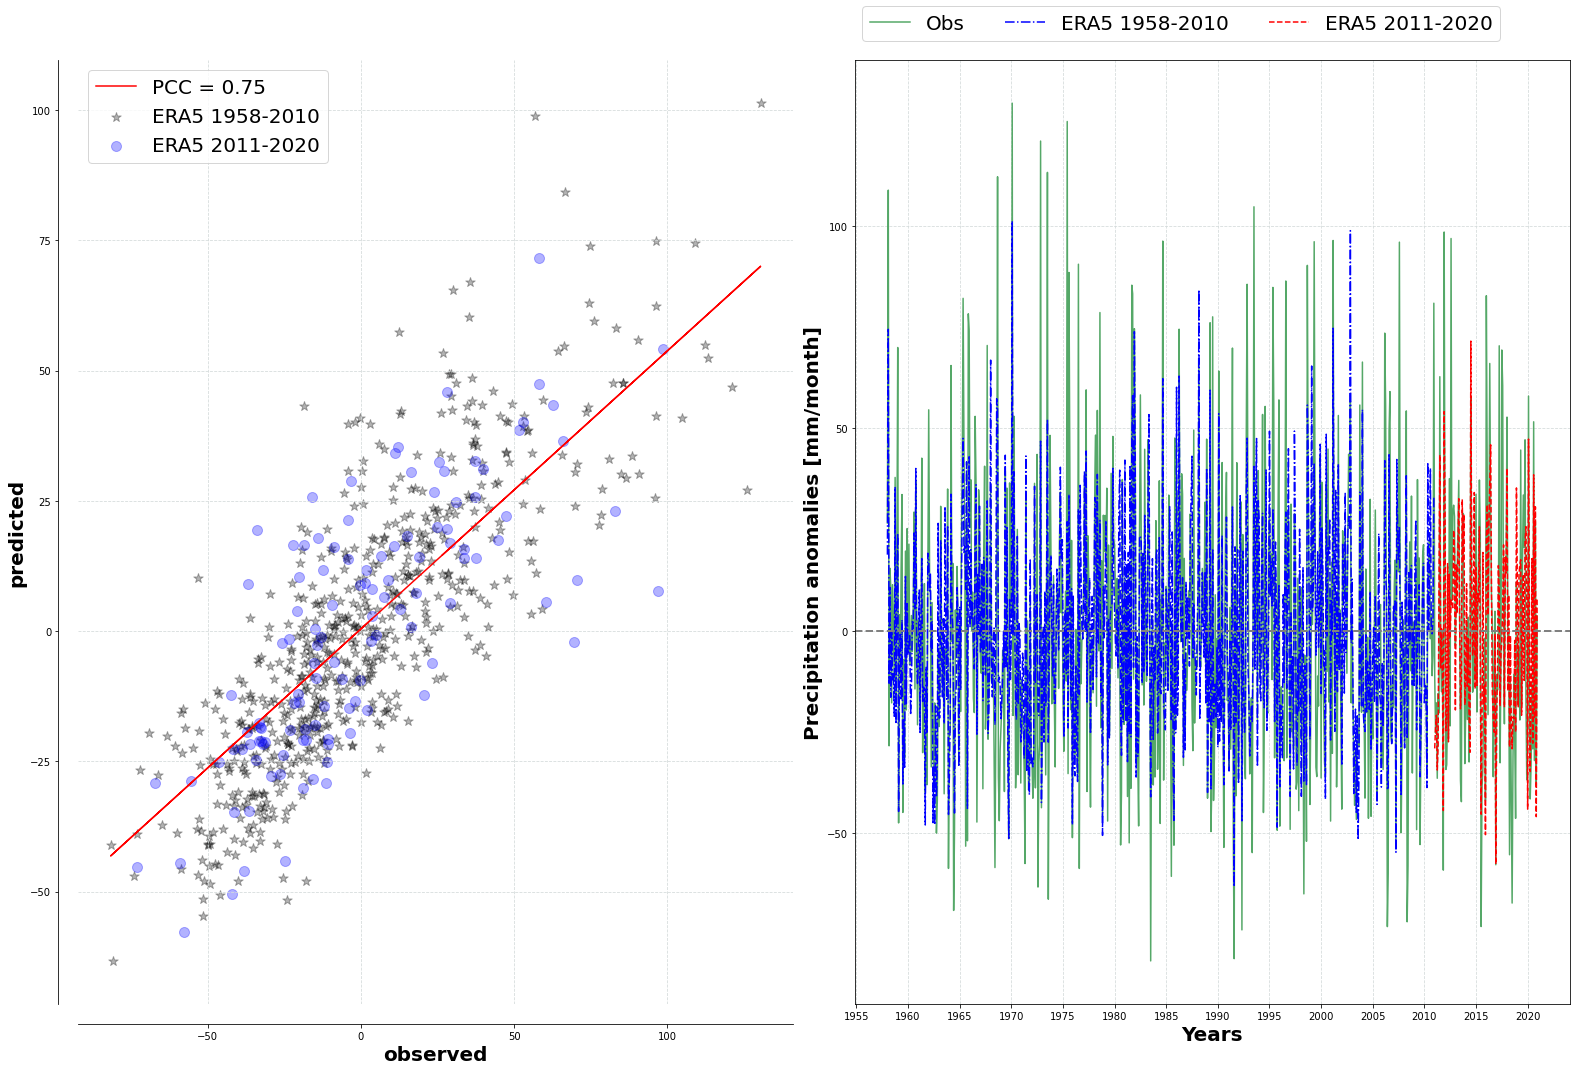

In [11]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,15), sharex=False)
scatterplot(station_num=1, stationnames=stationnames_prec, path_to_data=path_to_results, 
                filename="predictions_", ax=ax1, xlabel="observed", ylabel="predicted",
                method= "Stacking", obs_train_name="obs_train", obs_test_name="obs_test",
           obs_full_name="obs_full")
    
lineplot(station_num=1, stationnames=stationnames_prec, path_to_data=path_to_results, 
            filename="predictions_", ax=ax2, fig=fig, ylabel="Precipitation anomalies [mm/month]",
            xlabel= "Years", method= "Stacking", obs_train_name="obs_train", obs_test_name="obs_test", 
        obs_full_name="obs_full")